In [1]:
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt

def create_fake_timeseries_data(num_days=500, seed=42):
    """
    生成模拟的温度传感器数据:
      - temp(目标) + humidity + day_of_week
      - 每天一条记录, 并随机制造部分缺失和异常值
    """
    np.random.seed(seed)
    random.seed(seed)

    dates = pd.date_range(start="2021-01-01", periods=num_days, freq='D')
    day_of_week = dates.dayofweek  # 0=Monday, 6=Sunday

    # 模拟温度: baseline=20, 带周期性和噪声
    temp = 20 + 5 * np.sin(np.arange(num_days) * 2*np.pi/365) + np.random.randn(num_days)*1.5

    # 模拟湿度: 在30~70%之间随机波动
    humidity = 50 + 20*np.random.randn(num_days)
    humidity = np.clip(humidity, 30, 70)

    df = pd.DataFrame({
        'date': dates,
        'temp': temp,
        'humidity': humidity,
        'day_of_week': day_of_week
    })
    df.set_index('date', inplace=True)

    # 制造缺失值 (NaN)
    for _ in range(5):
        idx = np.random.randint(0, num_days)
        df.iloc[idx, 0] = np.nan  # 在 temp 列制造缺失
    for _ in range(5):
        idx = np.random.randint(0, num_days)
        df.iloc[idx, 1] = np.nan  # 在 humidity 列制造缺失

    # 制造异常值
    anom_idx = np.random.randint(0, num_days)
    df.iloc[anom_idx, 0] = 200  # 温度异常极高
    return df

df = create_fake_timeseries_data(num_days=500)

print("Data sample:")
print(df.head(10))

Data sample:
                 temp   humidity  day_of_week
date                                         
2021-01-01  20.745071  68.523551            4
2021-01-02  19.878670  70.000000            5
2021-01-03  21.143641  30.000000            6
2021-01-04  22.542643  61.259385            0
2021-01-05  19.992782  36.987149            1
2021-01-06  20.078619  40.257492            2
2021-01-07  22.884328  38.152122            3
2021-01-08  21.752192  32.720185            4
2021-01-09  19.982182        NaN            5
2021-01-10  21.585384  33.380998            6


In [2]:
# 查看缺失值情况
missing_count = df.isna().sum()
print("Missing Values:\n", missing_count)

# 用前向填充，再用后向填充补充
df = df.fillna(method='ffill').fillna(method='bfill')

Missing Values:
 temp           5
humidity       5
day_of_week    0
dtype: int64


C:\Users\yyx\AppData\Local\Temp\ipykernel_14552\44038095.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [3]:
unreasonable_mask = (df['temp'] < -10) | (df['temp'] > 50)
if unreasonable_mask.any():
    print("Anomaly found, auto-correcting by neighbor values.")
    anomaly_indices = df[unreasonable_mask].index
    for idx in anomaly_indices:
        # 用前一天或后一天均值替换
        df.loc[idx, 'temp'] = (df.loc[idx - pd.Timedelta(days=1), 'temp'] +
                               df.loc[idx + pd.Timedelta(days=1), 'temp']) / 2

Anomaly found, auto-correcting by neighbor values.


In [4]:
df['temp_diff'] = df['temp'].diff().fillna(0)  # 对首行差分补0
# one-hot
df_week = pd.get_dummies(df['day_of_week'], prefix='dow')
df = pd.concat([df, df_week], axis=1)

df.drop(columns=['day_of_week'], inplace=True)

df.head()

,temp,humidity,temp_diff,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
date,,,,,,,,,,
2021-01-01,20.745071,68.523551,0.000000,False,False,False,False,True,False,False
2021-01-02,19.878670,70.000000,-0.866401,False,False,False,False,False,True,False
2021-01-03,21.143641,30.000000,1.264971,False,False,False,False,False,False,True
2021-01-04,22.542643,61.259385,1.399002,True,False,False,False,False,False,False
2021-01-05,19.992782,36.987149,-2.549861,False,True,False,False,False,False,False


In [5]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = ['temp','humidity','temp_diff'] + list(df_week.columns)
# 目标: next-day temp，用当前天这些特征

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[feature_cols].values)
# df_scaled shape: (num_days, len(feature_cols))
print("Scaled shape:", df_scaled.shape)

Scaled shape: (500, 10)


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data_array, seq_len=14, target_col=0):
        """
        :param data_array: 已归一化的 2D numpy, shape=(num_samples, num_features)
        :param seq_len: 过去多少天作为输入
        :param target_col: temp 对应列索引(这里默认为0)
        """
        self.data = data_array
        self.seq_len = seq_len
        self.target_col = target_col

    def __len__(self):
        # 用最后一天预测 => (num - seq_len)
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_len, :]   # (seq_len, num_features)
        y = self.data[idx + self.seq_len, self.target_col]  # 标量
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

SEQ_LEN = 14
TARGET_COL_IDX = 0  # temp在feature_cols中的索引=0
dataset = TimeSeriesDataset(df_scaled, seq_len=SEQ_LEN, target_col=TARGET_COL_IDX)

# 训练集/测试集划分: 比如前 400 天训练, 后面做测试
train_size = 400 - SEQ_LEN
train_dataset = TimeSeriesDataset(df_scaled[:400], seq_len=SEQ_LEN, target_col=TARGET_COL_IDX)
test_dataset  = TimeSeriesDataset(df_scaled[400:], seq_len=SEQ_LEN, target_col=TARGET_COL_IDX)

print("Train samples:", len(train_dataset))
print("Test  samples:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

Train samples: 386
Test  samples: 86


In [7]:
import torch.nn as nn
import math

class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_features, d_model=32, nhead=4, num_layers=2, dim_feedforward=64, dropout=0.1):
        """
        :param num_features: 输入特征数
        :param d_model: Transformer内部词向量维度
        :param nhead: Multi-head attention 数
        :param num_layers: TransformerEncoderLayer 堆叠层数
        :param dim_feedforward: 前馈层大小
        :param dropout: dropout 概率
        """
        super(TimeSeriesTransformer, self).__init__()

        self.d_model = d_model

        # 1) 线性 Embedding: 将 input_dim -> d_model
        self.input_embedding = nn.Linear(num_features, d_model)

        # 2) 可训练的位置编码 (也可用正余弦位置编码)
        self.pos_embedding = nn.Embedding(5000, d_model)  # 5000 仅作最大长度上限

        # 3) Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4) 最终回归输出
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        :param x: shape (batch, seq_len, num_features)
        :return: (batch, 1)
        """
        batch_size, seq_len, _ = x.size()

        # 线性变换 -> (batch, seq_len, d_model)
        x_embed = self.input_embedding(x)

        # 构建位置id [0,1,2,... seq_len-1]
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        # 位置编码 -> (batch, seq_len, d_model)
        pos_embed = self.pos_embedding(positions)

        # 将 x_embed + pos_embed 合并
        x_trans_in = x_embed + pos_embed  # (batch, seq_len, d_model)

        # 通过 TransformerEncoder
        encoded = self.transformer_encoder(x_trans_in)  # (batch, seq_len, d_model)

        # 取最后时刻的 hidden state
        last_step = encoded[:, -1, :]  # (batch, d_model)

        # 映射到回归输出
        out = self.fc_out(last_step)   # (batch, 1)

        return out.squeeze(-1)         # (batch,)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TimeSeriesTransformer(
    num_features=len(feature_cols),
    d_model=32,
    nhead=4,
    num_layers=2,
    dim_feedforward=64,
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # (batch, seq_len, feature_dim)
        batch_y = batch_y.to(device)  # (batch,)

        optimizer.zero_grad()
        pred = model(batch_x)  # (batch,)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    if (epoch+1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [2/10], Loss: 0.0081
Epoch [4/10], Loss: 0.0089
Epoch [6/10], Loss: 0.0089
Epoch [8/10], Loss: 0.0080
Epoch [10/10], Loss: 0.0074


In [19]:
model.eval()
preds = []
targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        pred = model(batch_x)  # (batch,)
        preds.append(pred.cpu().numpy())
        targets.append(batch_y.numpy())

import numpy as np
preds = np.concatenate(preds)
targets = np.concatenate(targets)

# 计算MSE, MAE
mse_test = np.mean((preds - targets)**2)
mae_test = np.mean(np.abs(preds - targets))
print(f"Test MSE: {mse_test:.4f}, Test MAE: {mae_test:.4f}")

Test MSE: 0.0104, Test MAE: 0.0842


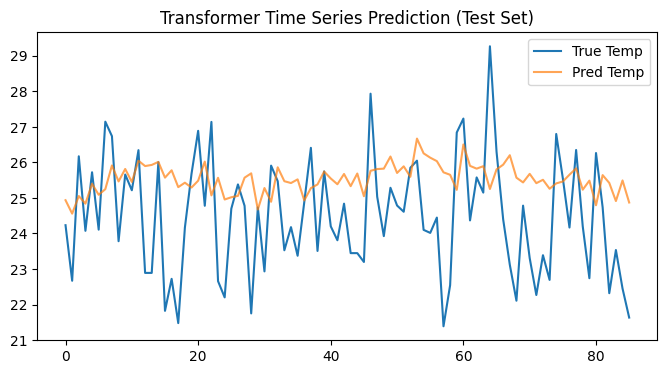

In [20]:
from sklearn.preprocessing import MinMaxScaler

def inverse_transform(values, scaler, feature_index=0):
    # values shape=(N,)
    # 构造 dummy array: (N, feature_dim)
    dummy = np.zeros((len(values), len(feature_cols)))
    dummy[:, feature_index] = values
    inv = scaler.inverse_transform(dummy)
    return inv[:, feature_index]

preds_real = inverse_transform(preds, scaler, feature_index=0)
targets_real = inverse_transform(targets, scaler, feature_index=0)

plt.figure(figsize=(8,4))
plt.plot(targets_real, label='True Temp')
plt.plot(preds_real, label='Pred Temp', alpha=0.7)
plt.title("Transformer Time Series Prediction (Test Set)")
plt.legend()
plt.show()